# Automated Discovery of Temperature Dependent Structural Change

    Neutron powder diffraction is a powerful way to examine the atomic structure of technologically interesting materials. The particular material from this data set is a candidate for solar cells . Nevertheless, the same methods are used in battery materials, catalysts, etc. A single data set has 2 dimensions: Intensity(I) and d spacing (d). The d spacing is a characteristic structural scale in the system. If there is a large I at a given d, that means there are at least two atoms spaced at that distance in the system. If I is at the background it means there is nothing with that d spacing in the material.
    
    Often functional behavior is related to a structural change with an external parameter like temperature. This structural change show up as change in the existence, position or width of the peaks. The provided data set is a collection of I vs d curves at multiple temperatures. So the data set is 3 dimensional I(d,T). The data is in an HDF5 file. H5py is a useful set of libraries for accessing HDF5 files from python. If you are not familiar with hdf5 and want to browse the data structure want to browse the data structure we recommend hdfview or nexpy. However, the developed algorithms should run independently of these codes.

# Challenge
    Given the aforementioned data set, here are the challenge questions
    
    1. Provide an algorithm that given the data set as an input, provides the temperature of the structural transition.
    2. Provide an algorithm that gives the integrated area under, the center of intensity, and a characteristic width for the peak that is between 3.2 and 3.3 Å in d spacing as a function of temperature.
    3. Provide an algorithm that gives the integrated area under, the center of intensity, and a characteristic width for all peaks at a given Temperature.
    4. Given adjacent temperatures, provide an algorithm that indicates if a phase transition occurred between the two temperatures, a list of centers, widths, and intensities for all peaks in the data set that are at least 1.5x above background in under 5 seconds

    Our preference is for the algorithms to be implemented in Python with use of the numpy library, other necessary libraries are welcome. If the participant prefers a compiled code, C/C++, is our preferred solution with the output being in a python or numpy data structure.

In [1]:
import numpy as np
import scipy as sp

#import h5py
import matplotlib.pyplot as plt
import matplotlib as mpl
#%matplotlib notebook
%matplotlib inline
mpl.rcParams['savefig.dpi'] = 300

from nexusformat.nexus import *
import warnings
warnings.filterwarnings('ignore')

from IPython.core.pylabtools import figsize
np.set_printoptions(precision=3)

from matplotlib import rc
rc('text', usetex=True)

import os
os.makedirs('Q4/Data/', exist_ok=True)
os.makedirs('Q4/Figs/', exist_ok=True)

# Q0. Load the data, and convert the data into np arrays. 

In [2]:
ff = nxload('NPD_Temp.nxs')
data = ff.entry.data

'''to keep the nexus format. The data format are slightly difffernt to np array.'''
_intsy = data['intensity']
_QQs = data['Q']
_dds = data['dspacing']
_temps = data['temperature']

'''convert to numpy array'''
intsy = np.asarray(_intsy)
QQs = np.asarray(_QQs)
dds = np.asarray(_dds)
temps = np.asarray(_temps)
dd_cs = (dds[:-1]+dds[1:])/2
temp_cs = (temps[:-1]+ temps[1:])/2


# Q4 Given adjacent temperatures, provide an algorithm that indicates if a phase transition occurred between the two temperatures, a list of centers, widths, and intensities for all peaks in the data set that are at least 1.5x above background in under 5 seconds.

## 4.1 Using DBSCAN to find the signal points, which are used to determine the similarity between them. Based on this information, we calcuate the likehood of a phase transtion between these two temperatures. 

    * Overall, the accuracy of phase transion prediction based on just two datasets is much lower than using the global information, as illustrated in Q1. 
    

In [3]:
from numba import jit

#@jit
def cal_likehood(intsy, _temps, temp0, temp1=-1, nnpts=3, gamma = 6):
    '''
    calcualte the structure phase transiton likehood between two temperatures. 
    If temp1 is not given, then use the next higher temperature, unless temp0 is maximum
    temperautre in the dataset.  In the lastter case, calculate the next lower temperature.  
    nnpt: number of neighbor points to be included in each side. 
    
    add a sensitive factor 6.  larger, more sensitive to small change
    '''
    from sklearn.cluster import DBSCAN
    
    _, nbins = intsy.shape
    
    ii = _temps.index(temp0)
    if temp1 > 0:
        jj = _temps.index(temp1)
    elif ii == len(_temps)-1:
        jj = ii-1
    else:
        jj = ii+1
    
    data_0 = intsy[ii, :].flatten()
    data_1 = intsy[jj, :].flatten()
    xx, yy = np.meshgrid(np.arange(nbins), [0])
    pnt_loc = np.vstack((xx.flatten(), yy.flatten())).T

    bkg0 = np.percentile(data_0, 50)
    bkg1 = np.percentile(data_1, 50)
    ncutoff = (2 * nnpts + 1) * 3
    db0 = DBSCAN(eps = nnpts, min_samples = bkg0*ncutoff, 
                 n_jobs=-1).fit(pnt_loc, sample_weight = data_0)
    db1 = DBSCAN(eps = nnpts, min_samples = bkg1*ncutoff, 
                 n_jobs=-1).fit(pnt_loc, sample_weight = data_1)

    coreloc_0 = pnt_loc[db0.labels_ != -1][:, 0]
    coreloc_1 = pnt_loc[db1.labels_ != -1][:, 0]
    #print(temp0, len(coreloc_0), len(coreloc_1))
    likehood = _likehood(coreloc_0, coreloc_1, gamma)
 
    return  likehood

#@jit
def cal_likehood_fullT(intsy, nnpts=3, gamma = 6):
    '''
    calcualte the structure phase transiton likehood between adjacent temperatures from the 
    2D NPD data. 
    
    nnpts: neighboring point used to calcuate the signal point above background. 
    gamma, sensitive factor, more sensitive to small changes.
    '''
    from sklearn.cluster import DBSCAN
    
    npars, nbins = intsy.shape 
    ncutoff = (2 * nnpts + 1) * 3
    
    xx, yy = np.meshgrid(np.arange(nbins), [0])
    pnt_loc = np.vstack((xx.flatten(), yy.flatten())).T
    
    coreloc = []
    for ii in range(npars):
        data = intsy[ii, :].flatten()
        bkg = np.percentile(data, 50)
        db = DBSCAN(eps = nnpts, min_samples = bkg*ncutoff, 
                 n_jobs=-1).fit(pnt_loc, sample_weight = data)
        coreloc.append(pnt_loc[db.labels_ != -1][:, 0])
    
    likehood = []
    for ii in range(npars-1):
        likehood.append(_likehood(coreloc[ii], coreloc[ii+1], gamma))
 
    return  likehood

@jit
def _likehood(coreloc0, coreloc1, gamma = 6):
    '''
    a likehood function to describe the probability of a phase transition happended 
    between the two datasets by comparsion the different core members.
    
    nnpts: neighboring point used to calcuate the signal point above background. 
    gamma, sensitive factor, more sensitive to small changes.
    '''
    core0, core1 = set(coreloc0), set(coreloc1)
    
    comm = core0 & core1 
    ntot, ncomm = len(core0) + len(core1), len(comm)
    ndiff = ntot - 2 * ncomm
    #print(ntot, ncomm, ndiff)
    if ncomm == 0 & ndiff != 0:
        likehood = 1
    else:
        reg = np.tan((ndiff/ntot - 0.5 ) * np.pi)
        #print(ntot, ncomm, ndiff, ndiff/ntot, reg)
        likehood = 1/(1 + np.exp(-(reg+gamma)))
        
    return likehood



In [4]:
temp = 80
print('The likehood of a phase transtion at %d K is %f' %(temp, cal_likehood(intsy, _temps, temp)))

The likehood of a phase transtion at 80 K is 0.158021


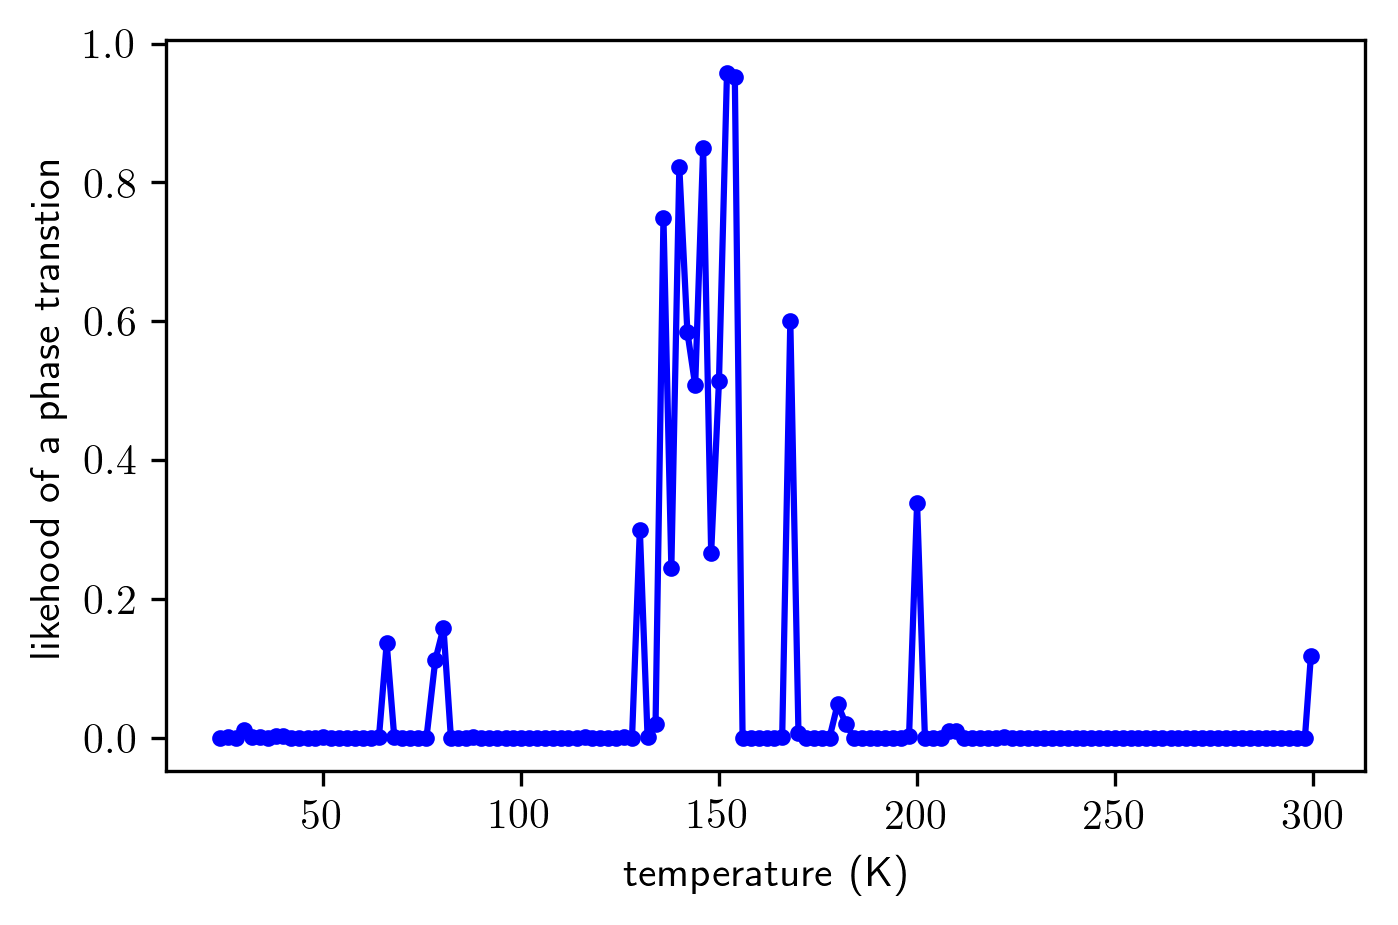

In [5]:
# slightly change the code to calcuate the likehood from all temperatures. 
likeh = cal_likehood_fullT(intsy)
figsize(4.8, 3.2)
plt.plot(temp_cs, np.asarray(likeh), '.-', color='blue')
plt.ylabel('likehood of a phase transtion')
plt.xlabel('temperature (K)')
plt.tight_layout()
plt.savefig('Q4/Figs/PhaseTransition_Likehood_allT')

## 4.2 Create peak table for all temperatures, simialr to what was done in Q3.

    two-segement peak finding with modified ricker wavelet, filter the false peak finding by neighboring peak distances and amplitudes.



In [6]:
from numba import jit

@jit
def cal_peaktables_fullT(intsyMap, _pars, bin_cs):
    '''
    _pars : NXfiled
    '''

    _npars, nbins = intsyMap.shape
    
    peaktables = []
    for par in _pars:
        _peaktable = find_peaks_flow(intsyMap, _pars, bin_cs, par_val=par)
        peaktables.append(_peaktable)
    
    return peaktables
 

@jit
def _ricker_asy(points, a):
    """
    A modified ricker wavelet based on the powder diffraction peak shape. 
    """
    alpha = 0.8
    
    A = 0.5 / (a  * (np.pi**0.5))
    wsq = a**2
    
    vec = np.arange(0, points) - (points - 1.0) / 2
    vec[np.int(points/2):] *=-alpha
    xsq = vec**2
    vec_oa = vec/a 
    
    mod = (1 - xsq / wsq)
    gauss = np.exp(-xsq / (2 * wsq))
    total = A * mod * gauss
    return total

#@jit
def find_peaks_flow(IntsyMap, _pars, bin_cs, par_val=0, sep = 1/4., min_dis=2, 
                    wavelet=_ricker_asy, bkg=0):
    '''
    pars: NXfield
    
    If a non-zero background term (float) is given, then it assumes that background is 
    predetermined and a background-removed dataset is given. the given value will be 
    the cutoff value.
    
    Otherwise it use 50 percentile value as the background limit. A cutoff value will 
    be calcualted. 
    '''
    from scipy.optimize import least_squares
    
    data = intsy[_pars.index(par_val)].flatten()
    peakindx = _find_peaks_by_indx(data, dd_cs, sep=sep, min_dis=min_dis, wavelet=wavelet) 
    
    if(bkg != 0):
        _Bkg = []
        cutoff = bkg
    else:
        _Bkg = [np.percentile(data, 50)]
        cutoff = np.percentile(data, 50) + data[data<np.percentile(data, 50)].std()
    
    
    par_ini, bounds= Ini_Mpeaks_pars(data, peakindx, dd_cs, Bkg=_Bkg)
    fit = least_squares(Mpeaks_LS, par_ini, bounds=bounds, 
                        args=(data, peakindx, dd_cs, len(_Bkg)))
    model = Mpeaks_model(fit.x, data, peakindx, dd_cs, NoBkg=len(_Bkg))
    peaktable = gen_peaktable(fit.x, _dds, peakindx, NoBkg=len(_Bkg), cutoff=cutoff)
    
    return peaktable


#@jit
def _find_peaks_by_indx(data, bin_cs, sep = 1/4, min_dis=2, wavelet=_ricker_asy):
    '''
        a new version of find_peaks(). only deal a single dataset
        
        1. cut the data into two segements. [0, sep] and [sep, 1]
        2. find peak in each segement and merge the peak together.
        
        3. combined peaks if their distance is less than a min_distance
        '''
    from scipy.signal import find_peaks_cwt
    
    if sep < 0 or sep > 1:
        raise ValueError("seperation value should be in (0, 1]")
        
    
    nbins = data.size
    bin_cutoff = int(sep * nbins)
    bin_0, bin_1 = int(bin_cutoff * 1.02), int(bin_cutoff * 0.98)
    data_0, data_1 = data[:bin_0], data[bin_1:]
    
    wws = np.arange(2, 9, 1)
    minlength = 3
    SNr = 1.2
    peakind_0 = find_peaks_cwt(data_0, wws, wavelet=wavelet, 
                                         min_length = minlength, min_snr=SNr, noise_perc=10)
    peakind_0 = peakind_0[:-1] if peakind_0[-1] > bin_cutoff else peakind_0
    
    if sep < 1 :
        wws = np.arange(3, 14, 1.5)
        minlength = 3
        SNr = 2.
        peakind_1 = find_peaks_cwt(data_1, wws, wavelet=wavelet, 
                                             min_length = minlength, min_snr=SNr, noise_perc=10)
        # updated to the original bin index
        peakind_1 += bin_1
        peakind_1 = peakind_1[1:] if peakind_1[0] < bin_cutoff else peakind_1

        peakind = np.sort(np.concatenate((peakind_0,peakind_1),0))
    else:
        peakind = peakind_0
    
    peakind = _peak_cleanup_by_distance(peakind, min_dis)
    
    return peakind



@jit 
def _peak_cleanup_by_distance(peakindx, min_dis, lens=0):
    ''' 
    Define a quick way to remove one of the higher-indexed (index: ii+1) peak if two adjacent 
    peaks are too close to each other,  unless the lower-indexed peak (ii) has been removed 
    and the distance between peaks ii+1 and ii-1 is more thatn min_dis. 
    No more iterations is checked beyond this. 
    There is an option to remove peaks too close to the edges, if lens is defined.
    --
    Input: 
        peak index array.
        minimum index distance.
    Output:
        A new peak index array
    '''
    
    if lens > 0:
        peakindx = peakindx[peakindx > min_dis]
        peakindx = peakindx[peakindx < (lens - min_dis)]
    
    npeaks = peakindx.size
    if npeaks > 0:
        unique_peak=[peakindx[0]]
    else:
        return np.asarray([])
    
    if npeaks > 1:
        dist = peakindx[1:] - peakindx[:-1]
        ii=0
        for ii in range(dist.size):
            if dist[ii] >= min_dis:
                unique_peak.append(peakindx[ii+1])
            elif ii>0 & (dist[ii]+dist[ii-1]) >= min_dis:
                unique_peak.append(peakindx[ii+1])

    return np.asarray(unique_peak)


@jit
def Ini_Mpeaks_pars(Intsy, peakind, bin_cs, Bkg=[70, 0], 
                    peakwidth_pars=[1e-3, 2e-4, 6e-4], dtol=6e-4):
    '''
    set up a fitting function including all peaks and a background term
        background: OrderofBkg + 1
            limits can be tuned by experience. [-10, 10] for non-zero order
        resolution: 3, peak_width = C0 + C1*d + C2*d^2, [0, 0.1^n]
        peak amplitude: npeaks, [0, inf]
        peak center : npeaks, [d_c*(1-dtol), d_c*(1+dtol)]
        
        jj: parameter index
    '''
    npeaks = peakind.size
    NoBkg = len(Bkg)
    nCoef = NoBkg + 3 + npeaks * 2 
    par_ini, low_lmt, high_lmt= np.zeros(nCoef), np.zeros(nCoef), np.zeros(nCoef)
    
    # background
    if NoBkg >0:
        par_ini[:NoBkg] = Bkg
        high_lmt[0] = Intsy.mean()
        if NoBkg > 1:
            low_lmt[1:NoBkg], high_lmt[1:NoBkg] = -10, 10
    
    # peak width, all peak width parameters are positively defined.  
    jj = NoBkg
    par_ini[jj:jj+3] =  peakwidth_pars
    high_lmt[jj:jj+3] = [4e-3, 2e-3, 1e-3]
    
    #peak amplitude, all peak width terms are positively defined.
    jj += 3
    maxbin = bin_cs.size
    for ii in range(0, npeaks):
        _centerbinindx = peakind[ii]
        _low, _high = max(0, _centerbinindx - 4), min(maxbin-1, _centerbinindx + 4)
        _data_max = Intsy[_low:_high].max()
        par_ini[jj]  = _data_max
        high_lmt[jj] = _data_max *1.2
        jj+=1
    
    #peak center
    peaks_ctr = bin_cs[peakind]
    par_ini[jj:jj+npeaks] = peaks_ctr[:]
    low_lmt[jj:jj+npeaks], high_lmt[jj:jj+npeaks] = peaks_ctr[:]*(1-dtol), peaks_ctr[:] * (1+dtol)
    
    bounds =tuple([low_lmt, high_lmt])
    return par_ini, bounds 

@jit
def Mpeaks_LS(Coef, Intsy, peakind, bin_cs, NoBkg=2):
    '''
    use with scipy.optimize.least_squares
    call Mpeaks_model_1d() to calculate the model results and 
    reutrn the difference between model and data
    '''
    model = Mpeaks_model(Coef, Intsy, peakind, bin_cs, NoBkg)
    mask = model > 0
    diff = model[mask]-Intsy[mask]
    
    return  diff # it expects a 1D array out. 

@jit
def Mpeaks_model(Coef, Intsy, peakind, bin_cs, NoBkg=2):
    '''
    set up a fitting function including all peaks and a background term
        1. background: OrderofBkg + 1
        2. resolution: 3, peak_width = C0 + C1*d + C2*d^2, [0, 0.1^n]
        3. peak amplitude: npeaks, [0, inf]
        4. peak center : npeaks, [d_c*(1-dtol), d_c*(1+dtol)]
    
    return the model results.
    '''
    npeaks = peakind.size
    npts = Intsy.size
    
    # model bkg, polynominal 
    jj = 0
    if NoBkg > 0:
        model = np.full(npts, np.float(Coef[0]))
        jj += 1
        if NoBkg > 1:
            bins_jj = bin_cs.copy() 
            for ii in range(1, NoBkg):
                model += Coef[ii] * bins_jj
                jj += 1
                if(ii+1 < NoBkg): bins_jj*= bin_cs
    else:
        model = np.full(npts, 0.)
        
    _C0, _C1, _C2 = Coef[jj:jj+3]  
    jj += 3
    
    # model peaks, each peak is of shape A0 * exp[ (xx -A1)**2 / A2
    # calcuate for region +/- 12 pixels, which is sufficent.
    # each peak needs extra two parameters
    max_indx = npts -1
    for ii in range(0, npeaks):
        # index range for peak ii
        _centerbinindx = peakind[ii]
        _low, _high = max(0, _centerbinindx - 12), min(max_indx, _centerbinindx + 12)
        #calculate the relative distance to peak center and define a single peak
        _peak_center = Coef[jj+npeaks]
        _sigma = _C0 + _C1 * _peak_center + _C2 * _peak_center**2
        _dd_offset_sq = ((bin_cs[_low:_high] - _peak_center)/_sigma)**2
        _peak = Coef[jj] * np.exp(-_dd_offset_sq)
        model[_low:_high] += _peak 
        jj += 1
    return  model # it expects a 1D array out. 


@jit
def gen_peaktable(fitpars, _dds, peakindx, NoBkg=2, cutoff = 0):
    '''
    generate the peaktable from global peak fitting results
    dds: NXfield, used to calculte the integrated peak intensity
    peaktable: peak_pos, peak_amplitude,  peak_width
    '''
    npars = len(fitpars) - NoBkg - 3
    npeaks = len(peakindx)
    if npars != npeaks *2:
        raise ValueError("Dimension mismatch between peak parameters and peaks.")
    
    jj = NoBkg+3
    _C0, _C1, _C2 = fitpars[NoBkg:jj]  
    
    peaktable = np.empty([npeaks, 4])
    # [0] pos , [1] amplitude, [2] width, and [3] area
    _pos = fitpars[jj+npeaks:]  # in d value
    _amp = fitpars[jj:jj+npeaks]
    _sigma = _C0 + _C1 * _pos + _C2 * (_pos**2)
    _binsize = _dds[1:] - _dds[:-1]
    _sigma_in_bin = _sigma / _binsize[peakindx] 
    _area = (2* np.pi)**0.5 * _amp * _sigma_in_bin
    
    peaktable[:, 0] = _pos
    peaktable[:, 1] = _amp
    peaktable[:, 2] = _sigma
    peaktable[:, 3] = _area.flatten()
    
    if cutoff > 0:
        peaktable = peaktable[peaktable[:, 1] > cutoff]
    
    return peaktable


def plot_peakloc(intsymap, pars, bin_cs, peakloc, par_val=0, outputfilename = ""):
    '''
    plot the peak location figure.  
    '''
    
    # set up the figure properties
    rc('text', usetex=True)
        
    parindx = pars.index(par_val)
    data = intsy[parindx, :]
    
    # for plotting purpose
    data[data<0] = 0
    data_sqrt = data**0.5
    ylims = data_sqrt.max()
    
    plt.semilogx(bin_cs, data_sqrt, '.-', markersize=2, lw=1)
    npeaks = len(peakloc)
    plt.semilogx(peakloc, np.full(npeaks, 3), '|', mfc=None, mec='r', mew=2, ms=8,
                    label='%d peaks' % (len(peakloc)))

    plt.ylim(-ylims*0.1, ylims*1.2)
    title_ = 'T = %5.2f K' % (pars[parindx])
    plt.title(title_)
    plt.xlabel('d spacing (\AA)')
    plt.ylabel('\sqrt{Intensity}')
    plt.legend()
    plt.tight_layout()
    if len(outputfilename) > 0:
        plt.savefig(outputfilename)
    
    return

def plot_peakloc_indx(intsymap, pars, bin_cs, peakind, par_val=0, outputfilename = ""):
    '''plot the peak location figure from the peak index array.'''
    peakloc = bin_cs[peakind]
    plot_peakloc(intsymap, pars, bin_cs, peakloc, par_val, outputfilename = "")
    return   

In [ ]:
# peak table at a single temperature.
%timeit  find_peaks_flow(intsy, _temps, dd_cs, par_val=180)

The slowest run took 12.78 times longer than the fastest. This could mean that an intermediate result is being cached.
1 loop, best of 3: 356 ms per loop


In [ ]:
# peak tables for all temperatures.
%timeit cal_peaktables_fullT(intsy, _temps, dd_cs)

In [ ]:
_peaktables = cal_peaktables_fullT(intsy, _temps, dd_cs)
peaktables = np.vstack((temps, _peaktables))
np.save('Q4/Data/Peaktables_fullT', peaktables)

In [ ]:
npeaks=[]
for peaktable in _peaktables:
    npeaks.append(peaktable.size)

figsize(4.8, 3.2)
plt.plot(temps, npeaks, 'o-', color='b')
plt.xlabel('temperature (K)')
plt.ylabel('Peaks found')
plt.tight_layout()
plt.savefig('Q4/Figs/IdentifiedPeakNumbers')

## 4.2 Speed up for creating peaktables at all temperatures. 
    
    It take about 350 ms to generate a peak table from one temperature. Without MPI, it takes 80 s to create the peaktables for all temperatures (140). In the later case, we can calcualte the wavelet function and save in memeory to use for all temperature to save some time. 
    
    We can also potentially speed up by parallel computation using the MPI for Python package, since the peaktable generation at different temperatures is mutually indpendent. 
